# Multivariate regression tutorial: aragonite saturation state

Using data from the West Coast Ocean Acidification (WCOA) cruise, create two different multiple linear regression models to calculate aragonite saturation state ($\Omega_A$) between 30 and 300 dbar as a function of more commonly observed variables. This is similar to "Model 1" described in [the previous section](2-06b-implementing-multivariate-regression.ipynb), following [Juranek et al. (2009)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2009GL040778). Note that there are a couple of issues with this model that led Juranek et al. (2009) to select a different model: bias and multicollinearity.

Juranek, L. W., R. A. Feely, W. T. Peterson, S. R. Alin, B. Hales, K. Lee, C. L. Sabine, and J. Peterson, 2009: A novel method for determination of aragonite saturation state on the continental shelf of central Oregon using multi-parameter relationships with hydrographic data. Geophys. Res. Lett., 36, doi:10.1029/2009GL040778.

First import the necessary packages and load the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

import PyCO2SYS as pyco2

In [2]:
filename07 = 'data/wcoa_cruise_2007/32WC20070511.exc.csv'
df07 = pd.read_csv(filename07,header=29,na_values=-999,
                  parse_dates=[[6,7]])

We use the [PyCO2SYS](https://pyco2sys.readthedocs.io/en/latest/) package to calculate the carbonate system parameters. This gives us values for aragonite saturation state that we can put in our dataframe.

In [3]:
c07 = pyco2.sys(df07['ALKALI'], df07['TCARBN'], 1, 2,
               salinity=df07['CTDSAL'], temperature=df07['CTDTMP'], 
                pressure=df07['CTDPRS']);
df07['OmegaA'] = c07['saturation_aragonite'];

/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/PyCO2SYS/equilibria/p1atm.py:99: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS**0.5
/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/PyCO2SYS/equilibria/p1atm.py:577: RuntimeWarning: overflow encountered in power
  K1 = 10.0 ** -(pK1)
/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/PyCO2SYS/equilibria/p1atm.py:583: RuntimeWarning: overflow encountered in power
  K2 = 10.0 ** -(pK2)
/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/PyCO2SYS/equilibria/p1atm.py:603: RuntimeWarning: overflow encountered in power
  K1 = 10.0**-pK1
/Users/tconnolly/opt/miniconda3/envs/ms263-24/lib/python3.11/site-packages/PyCO2SY

## Model 1: Temperature, salinity, pressure, dissolved oxygen and nitrate:

* Temperature
* Salinity
* Pressure
* Oxygen
* Nitrate

$$\hat{\Omega}_A = c_{0} + c_{1} \times T + c_{2} \times S + c_{3} \times p + c_{4} \times O_2 + c_{5} \times N$$

First, create a subset of all good data between 30-300 dbar. 

In [4]:
ii = ((df07['CTDPRS'] >= 30) & (df07['CTDPRS'] <= 300) &
      (df07['NITRAT_FLAG_W'] ==2) & (df07['PHSPHT_FLAG_W'] ==2) &
      (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] ==2) &
      (df07['TCARBN_FLAG_W'] == 2) & (df07['ALKALI_FLAG_W'] == 2) & 
      (df07['LATITUDE'] > 41) & (df07['LATITUDE'] < 48))

In [5]:
df07sub = df07[ii]

In [6]:
y = df07sub['OmegaA']

Solve for the coefficients $\vec{c}$ in the least squares problem:

$$ \hat{y} = \textbf{X}\vec{c} $$ 

Create a 2-D array `X` that contains a column of all ones, and additional columns containing the explanatory variables. This 2-D array is called the "design matrix" and should have six columns. What are the explanatory variables in this case? 

* Approach: use `np.ones()` to create a 2-D array of correct size, then fill in the columns.

In [7]:
k = 5 # number of predictor variables
N = len(df07sub['OmegaA']) # number of observations 

In [8]:
N

159

In [9]:
X = np.ones([N, k+1])

In [10]:
np.shape(X)

(159, 6)

In [11]:
X[:,1] = df07sub['CTDTMP']
X[:,2] = df07sub['CTDSAL']
X[:,3] = df07sub['CTDPRS']
X[:,4] = df07sub['CTDOXY']
X[:,5] = df07sub['NITRAT']

In [12]:
X

array([[  1.   ,   6.395,  33.91 , 250.   , 114.9  ,  31.63 ],
       [  1.   ,   7.163,  33.8  , 175.2  , 145.2  ,  27.63 ],
       [  1.   ,   7.131,  33.65 , 152.2  , 182.3  ,  24.67 ],
       [  1.   ,   7.727,  33.38 , 131.2  , 186.5  ,  23.01 ],
       [  1.   ,   8.203,  32.7  , 109.3  , 259.9  ,  11.88 ],
       [  1.   ,   8.266,  32.47 ,  89.5  , 286.7  ,   7.1  ],
       [  1.   ,   8.624,  32.42 ,  70.5  , 294.7  ,   5.9  ],
       [  1.   ,   8.754,  32.39 ,  60.6  , 297.5  ,   5.61 ],
       [  1.   ,   9.656,  32.39 ,  49.1  , 300.7  ,   4.56 ],
       [  1.   ,  10.23 ,  32.39 ,  38.7  , 298.4  ,   4.1  ],
       [  1.   ,  10.683,  32.39 ,  30.4  , 295.1  ,   3.95 ],
       [  1.   ,   6.877,  33.99 , 249.8  ,  74.6  ,  33.81 ],
       [  1.   ,   7.55 ,  33.9  , 174.5  , 101.9  ,  30.   ],
       [  1.   ,   8.012,  33.74 , 128.9  , 126.6  ,  27.95 ],
       [  1.   ,   7.944,  32.84 ,  89.3  , 234.4  ,  14.97 ],
       [  1.   ,   8.507,  32.49 ,  71.1  , 280.5  ,   

Use `np.linalg.lstsq` to compute the set of coefficients, `c`.

In [13]:
result = np.linalg.lstsq(X,y)

/var/folders/z7/lmyk7sz94177j166ck0x63h80000gr/T/ipykernel_58373/2890136322.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  result = np.linalg.lstsq(X,y)


In [14]:
result

(array([-1.19029082e+00, -2.51555185e-03,  9.38753728e-02,  3.36570803e-04,
         5.61953385e-04, -4.24568174e-02]),
 array([0.77762969]),
 6,
 array([2.71587204e+03, 1.28264376e+03, 1.19159901e+02, 1.60456253e+01,
        4.80243679e+00, 3.53983652e-02]))

In [15]:
c = result[0]

In [16]:
c

array([-1.19029082e+00, -2.51555185e-03,  9.38753728e-02,  3.36570803e-04,
        5.61953385e-04, -4.24568174e-02])

Alternative solution using matrix multiplication:

$$\hat{c} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\vec{y}$$

In [17]:
c2 = np.linalg.inv(X.T@X)@X.T@y

In [18]:
c2

array([-1.19029082e+00, -2.51555185e-03,  9.38753728e-02,  3.36570803e-04,
        5.61953385e-04, -4.24568174e-02])

Now calculate the model values, $\hat{y}$.

In [19]:
yhat = X@c

## Assessing the model for bias

Plot model vs. observations. Note the systematic underestimate at high and low values of $\Omega_A$. The residual plot shows this even more clearly.

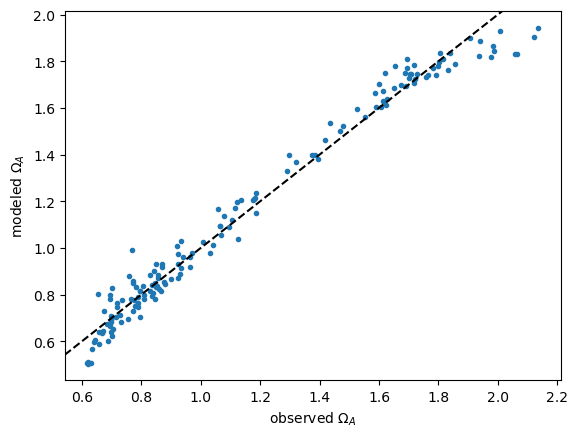

In [20]:
plt.figure()
plt.plot(y,yhat,'.')
xl = plt.xlim()
yl = plt.ylim()
plt.plot(xl, xl, 'k--')
plt.xlim(xl)
plt.ylim(yl)
plt.xlabel('observed $\Omega_A$')
plt.ylabel('modeled $\Omega_A$');

Plot residuals vs. observations.

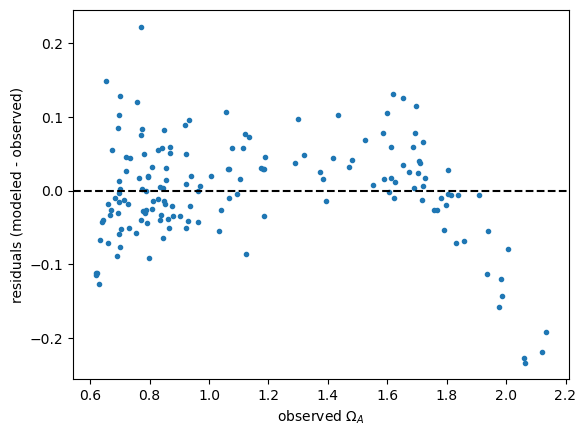

In [21]:
plt.figure()
plt.plot(y, yhat-y,'.')
xl = plt.xlim()
plt.plot(xl,[0,0],'k--')
plt.xlim(xl)
plt.xlabel('observed $\Omega_A$')
plt.ylabel('residuals (modeled - observed)');

### Alternative approach using statsmodels

Use `statsmodels` to get a complete summary of regression statistics. Note that the coefficients are the same as those obtained using Numpy above.

In [22]:
resultsm  = sm.OLS(y, X).fit()
print(resultsm.summary())

                            OLS Regression Results                            
Dep. Variable:                 OmegaA   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1230.
Date:                Tue, 27 Feb 2024   Prob (F-statistic):          1.44e-121
Time:                        18:20:08   Log-Likelihood:                 197.36
No. Observations:                 159   AIC:                            -382.7
Df Residuals:                     153   BIC:                            -364.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1903      2.013     -0.591      0.5

In [23]:
resultsm.params

const   -1.190291
x1      -0.002516
x2       0.093875
x3       0.000337
x4       0.000562
x5      -0.042457
dtype: float64

In [24]:
c

array([-1.19029082e+00, -2.51555185e-03,  9.38753728e-02,  3.36570803e-04,
        5.61953385e-04, -4.24568174e-02])

### Confronting multicollinearity

In the output above, statsmodels gave a warning about a high *condition number* - this is an indicator of how much a small change to the matrix $\textbf{X}$ will change the solution to the least squares problem $\hat{c} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\vec{y}$. It is a measure of the extent to which the columns in $\textbf{X}$ are linearly independent and closely scaled in magnitude. The same condition number can be calculated using Numpy.

In [25]:
np.linalg.cond(X)

76723.09230168296

Multiple collinearity can also be assessed by looking at the correlation matrix (R) or calculating the variance inflation factor (VIF).

In [26]:
R = df07sub[['CTDTMP', 'CTDSAL', 'CTDPRS', 'CTDOXY', 'NITRAT']].corr()

In [27]:
R

,CTDTMP,CTDSAL,CTDPRS,CTDOXY,NITRAT
CTDTMP,1.000000,-0.778421,-0.772172,0.822573,-0.863899
CTDSAL,-0.778421,1.000000,0.770493,-0.980860,0.979989
CTDPRS,-0.772172,0.770493,1.000000,-0.815279,0.786283
CTDOXY,0.822573,-0.980860,-0.815279,1.000000,-0.985540
NITRAT,-0.863899,0.979989,0.786283,-0.985540,1.000000


In [28]:
VIF = 1/(1 - R**2)

In [29]:
VIF

,CTDTMP,CTDSAL,CTDPRS,CTDOXY,NITRAT
CTDTMP,inf,2.537683,2.476778,3.092395,3.942003
CTDSAL,2.537683,inf,2.460989,26.375274,25.238230
CTDPRS,2.476778,2.460989,inf,2.982225,2.619453
CTDOXY,3.092395,26.375274,2.982225,inf,34.830366
NITRAT,3.942003,25.238230,2.619453,34.830366,inf


### Final model for aragonite saturation state

Due to issues with bias and multiple collinearity, the following alternative model proposed by Juranek et al. (2009). It is simpler and contains an interaction term.


$ \hat{\Omega}_A = a_0 + a_1 \times (O - Oref) + a_2 \times (O - Oref) \times (T - Tref) $

An important question is whether this model can predict aragonite saturation state in different years. This model can be tested using an independent data set from later cruises that cover the same region.